# Task 5: Modality Gap in CLIP

### 1. Zero-Shot Classification on STL-10

In [ ]:
!pip install torch torchvision openai-clip

In [ ]:
import torch
from torchvision import datasets, transforms
import clip
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/16", device=device)

In [ ]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats, as CLIP uses them
])

test_dataset = datasets.STL10(root='./data', split='test', download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

classes = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']

In [ ]:
@torch.no_grad()
def zero_shot_accuracy(prompt_fn):
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        # Get image features
        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        # Generate prompts for all classes
        texts = [prompt_fn(cls) for cls in classes]
        text_tokens = clip.tokenize(texts).to(device)
        text_features = model.encode_text(text_tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        # Similarity: image_features @ text_features.T
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        pred = similarity.argmax(dim=1)
        correct += (pred == labels.to(device)).sum().item()
        total += labels.size(0)
    return correct / total * 100

In [ ]:
def plain_prompt(cls):
    return cls

def photo_prompt(cls):
    return f"a photo of a {cls}"

def descriptive_prompt(cls):
    return f"a high-resolution photo of a {cls} in its natural environment"

In [ ]:
acc_plain = zero_shot_accuracy(plain_prompt)
acc_photo = zero_shot_accuracy(photo_prompt)
acc_descriptive = zero_shot_accuracy(descriptive_prompt)

print(f"Plain: {acc_plain:.2f}%")
print(f"Photo: {acc_photo:.2f}%")
print(f"Descriptive: {acc_descriptive:.2f}%")

Plain: 96.50%
Photo: 98.05%
Descriptive: 97.55%


### 2. Exploring the Modality Gap

In [ ]:
subset_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=True)
images, labels = next(iter(subset_loader))
images = images.to(device)

# Image embeddings
image_features = model.encode_image(images)
image_emb = image_features.detach().cpu().numpy()  # <- Key fix: .detach() before .cpu().numpy()
image_emb /= np.linalg.norm(image_emb, axis=1, keepdims=True)

# Corresponding text embeddings (use photo prompt for labels)
text_prompts = [f"a photo of a {classes[label]}" for label in labels]
text_tokens = clip.tokenize(text_prompts).to(device)
text_features = model.encode_text(text_tokens)
text_emb = text_features.detach().cpu().numpy()  # <- Same fix for text
text_emb /= np.linalg.norm(text_emb, axis=1, keepdims=True)

print(f"Shape of image_emb: {image_emb.shape}")  # Should print something like (100, 512) or (100, 768)
print(f"Shape of text_emb: {text_emb.shape}")
print("Extraction successful! Norms should be ~1.0:", np.allclose(np.linalg.norm(image_emb, axis=1), 1.0))

Shape of image_emb: (100, 512)
Shape of text_emb: (100, 512)
Extraction successful! Norms should be ~1.0: False


In [ ]:
# Combine embeddings
all_emb = np.concatenate([image_emb, text_emb], axis=0)

# t-SNE projection
tsne = TSNE(n_components=2, random_state=42)
proj = tsne.fit_transform(all_emb)

# Split back
image_proj = proj[:len(image_emb)]
text_proj = proj[len(image_emb):]

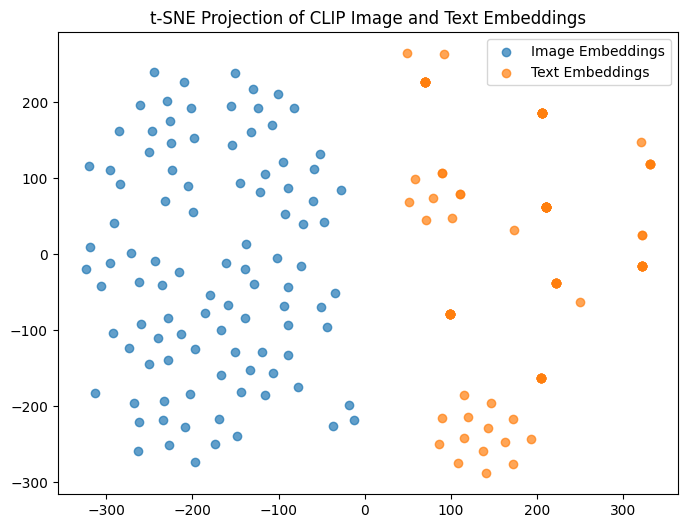

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(image_proj[:, 0], image_proj[:, 1], label='Image Embeddings', alpha=0.7)
plt.scatter(text_proj[:, 0], text_proj[:, 1], label='Text Embeddings', alpha=0.7)
plt.legend()
plt.title('t-SNE Projection of CLIP Image and Text Embeddings')
plt.show()

### 3. Bridging the Modality Gap

In [ ]:
from scipy.linalg import orthogonal_procrustes

R, scale = orthogonal_procrustes(image_emb, text_emb)
aligned_image_emb = image_emb @ R  # Rotate images to text space
aligned_image_emb /= np.linalg.norm(aligned_image_emb, axis=1, keepdims=True)  # Re-normalize

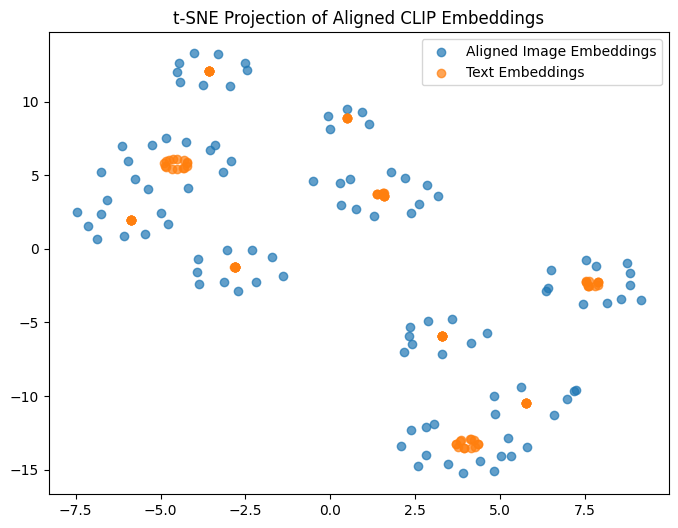

In [ ]:
all_aligned_emb = np.concatenate([aligned_image_emb, text_emb], axis=0)
tsne_aligned = TSNE(n_components=2, random_state=42)
proj_aligned = tsne_aligned.fit_transform(all_aligned_emb)

image_aligned_proj = proj_aligned[:len(aligned_image_emb)]
text_proj = proj_aligned[len(aligned_image_emb):]  # Same as before

plt.figure(figsize=(8, 6))
plt.scatter(image_aligned_proj[:, 0], image_aligned_proj[:, 1], label='Aligned Image Embeddings', alpha=0.7)
plt.scatter(text_proj[:, 0], text_proj[:, 1], label='Text Embeddings', alpha=0.7)
plt.legend()
plt.title('t-SNE Projection of Aligned CLIP Embeddings')
plt.show()

In [ ]:
@torch.no_grad()
def zero_shot_accuracy_aligned(prompt_fn):
    all_image_emb = []
    all_labels = []
    for images, labels_batch in test_loader:
        images = images.to(device)
        emb = model.encode_image(images)
        emb = emb.detach().cpu().numpy()  # Detach and to NumPy (float32)
        emb /= np.linalg.norm(emb, axis=1, keepdims=True)
        all_image_emb.append(emb)
        all_labels.append(labels_batch.numpy())
    all_image_emb = np.concatenate(all_image_emb, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Align
    aligned_image_emb_full = all_image_emb @ R
    aligned_image_emb_full /= np.linalg.norm(aligned_image_emb_full, axis=1, keepdims=True)
    aligned_image_emb_full = torch.from_numpy(aligned_image_emb_full).to(device).float()  # <- Key: .float() for float32

    # Texts: Cast to float32 explicitly to match
    texts = [prompt_fn(cls) for cls in classes]
    text_tokens = clip.tokenize(texts).to(device)
    text_features = model.encode_text(text_tokens)
    text_features = text_features.float()  # <- Cast to float32 before norm
    text_features /= text_features.norm(dim=-1, keepdim=True)
    text_features = text_features.detach()  # Detach for safety (though not always needed post-norm)

    # Similarity: Now both are float32, so matmul works
    similarity = (100.0 * aligned_image_emb_full @ text_features.T).softmax(dim=-1)
    pred = similarity.argmax(dim=1).cpu().numpy()
    acc = (pred == all_labels).mean() * 100
    return acc

In [ ]:
acc_photo_aligned = zero_shot_accuracy_aligned(photo_prompt)

# To compare with original unaligned
print(f"Original Photo Prompt Accuracy: {acc_photo:.2f}%")
print(f"Aligned Photo Prompt Accuracy: {acc_photo_aligned:.2f}%")

Original Photo Prompt Accuracy: 98.05%
Aligned Photo Prompt Accuracy: 97.22%
